In [137]:
import itertools
import matplotlib
import math
%matplotlib inline

In [138]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from tabulate import tabulate

In [157]:
class QuantumNeuralNetwork():
    def __init__(self, qubit_amount):
        # The last qubit is the ancilla qubit
        self._quantum_registers = QuantumRegister(qubit_amount, 'q')
        self._ancilla = QuantumRegister(1, 'ancilla')
        self._classical_register = ClassicalRegister(1, 'c')
        self._possible_qubits = self.get_possible_qubits(qubit_amount)
        self._circuit = QuantumCircuit(self._quantum_registers, self._ancilla, self._classical_register)
        return
        
    def get_possible_qubits(self, qubit_amount):
        inputs = []
        for x in map(''.join, itertools.product('01', repeat=qubit_amount)):
            inputs.append(x)
        return inputs
    
    def append_hadamard_gates(self):
        for qr in self._quantum_registers:
            self._circuit.h(qr)
        return

    def append_negative_gates_to_0_qubits(self, qubits):
        qr_num = 0
        for char_index in range(len(qubits)):
            qubit = qubits[char_index]
            if qubit == '0':
                self._circuit.x(self._quantum_registers[qr_num])
            qr_num += 1
        return
    
    def map_input_amplitudes_to_qubits(self, input):        
        headers = []
        index = 0
        for qr in self._quantum_registers:
            headers.append("q" + str(index))
            index += 1
        headers.append("ampl")
        
        qubits = []
        index = 0
        for entry in input:
            qubit = []
            qubits_string = self._possible_qubits[index]
            
            for char_index in range(len(qubits_string)):
                qubit.append(qubits_string[char_index])
            
            qubit.append(str(entry))
            qubits.append(qubit)
            
            index += 1
        
        print(tabulate(qubits, headers=headers))
        return
    
    def append_brute_force(self, input):
        qr = self._quantum_registers
        circuit = self._circuit
        if len(input) > len(self._possible_qubits):
            raise Exception("The number of values of the input is bigger than the possible amount of values")
            
        index = 0
        for entry in input:
            if entry < 0:
                self.append_negative_gates_to_0_qubits(self._possible_qubits[index])
                self._circuit.mcx(self._quantum_registers, self._ancilla, mode='noancilla')
                self.append_negative_gates_to_0_qubits(self._possible_qubits[index])
            index += 1                
        return
    
    def draw_circuit(self):
        self._circuit.measure(self._ancilla, self._classical_register)
        self._circuit.draw(output='mpl')
        return

  q0    q1    q2    ampl
----  ----  ----  ------
   0     0     0       1
   0     0     1      -1
   0     1     0       1
   0     1     1      -1
   1     0     0       1
   1     0     1      -1
   1     1     0       1
   1     1     1      -1


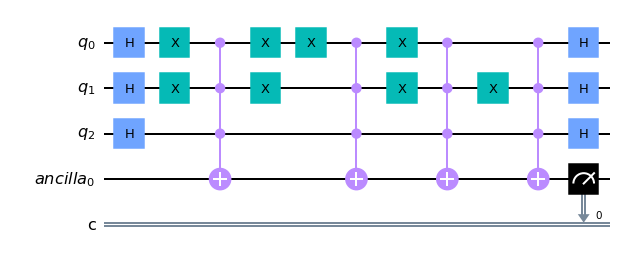

In [159]:
input = [1, -1, 1, -1, 1, -1, 1, -1]
nn = QuantumNeuralNetwork(3)

nn.append_hadamard_gates()
nn.append_brute_force(input)
nn.map_input_amplitudes_to_qubits(input)
nn.append_hadamard_gates()

nn.draw_circuit()
nn._circuit.draw(output='mpl')

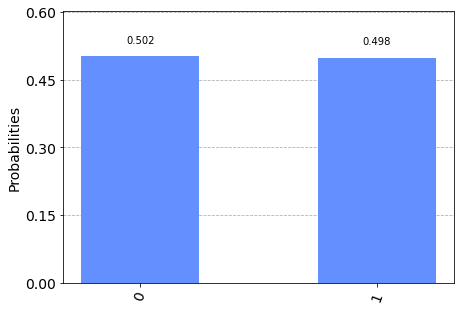

In [98]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(nn._circuit, backend = simulator).result()
plot_histogram(result.get_counts(nn._circuit))